This notebook explores some methods for intelligently (?) controlling the relative brightness of point and volume sources in the same volume rendering. 

https://github.com/yt-project/yt/issues/2614

There are two possible approaches that I see: 

* [Pre-rendering adjustment](#pre-rendering-adjustments), in which the $\alpha$ channel of the point source is set based on some estimate of the final brightness of the volume rendering (without having the rendering). 

* [Post-processing adjustment](#post-processing-methods), similar to the `sigma_clip` keyword

The second method is straightforward: any standard image processing method for contrast adjustment could be applied after rendering. The main downside is the limited adjustments that can be made in post (changing contrast can only do so much....). It would be ideal if we could get a sense before rendering of how bright the final volume will be given a transfer function. 

## pre-rendering adjustments 

First, let's load a dataset and pull out a variable:

In [1]:
%matplotlib inline
import numpy as np
import yt
from yt.visualization.volume_rendering.api import Scene, VolumeSource, PointSource
from yt.units import kpc
from skimage import exposure
import matplotlib.pyplot as plt

ds = yt.load("/home/chavlin/hdd/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030")

# create a scene and add volume sources to it

# Add density volume source 
field = "density"
ds._get_field_info(field).take_log = True

# pull out density (for histogram below)
al=ds.all_data()
dens=al['density'] # returns a unyt array 


yt : [INFO     ] 2020-07-15 11:51:44,630 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-07-15 11:51:44,631 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-07-15 11:51:44,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-07-15 11:51:44,632 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-07-15 11:51:44,632 Parameters: cosmological_simulation   = 0.0
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 20028.00it/s]
yt : [INFO     ] 2020-07-15 11:51:44,648 Gathering a field list (this may take a moment.)


Now let's set a transfer function and plot it along with a histogram. Doing so manually with matplotlib rather than the `transfer_function_helper`....

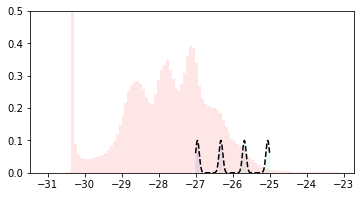

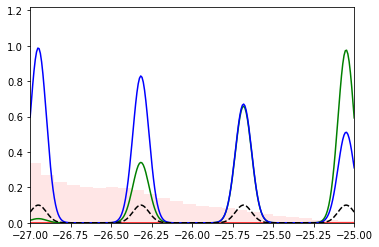

In [2]:

# set a tf! 
tf =  yt.ColorTransferFunction([-27, -25])
tf.clear()
# tf.add_layers(w=4, 0.001, alpha=np.logspace(-3, -1, 4), colormap="GnBu_r")
tf.add_layers(4, w=0.005, alpha=[.1,.1,.1,.1], colormap="winter")

# plot the transfer function m anually
y = tf.funcs[3].y
x = tf.funcs[3].x
w = np.append(x[1:]-x[:-1], x[-1]-x[-2])
colors = np.array([tf.funcs[0].y, tf.funcs[1].y, tf.funcs[2].y,
                   tf.funcs[3].y]).T

fig = plt.figure(figsize=[6, 3])
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
# ax.set_facecolor('black')
# d_hist=ax.hist(data['dvs'].ravel(),bins=100,density=True,log=False)

ax.hist(np.log10(dens.value),bins=100,density=True,color=[1.,.9,.9]);
ax.bar(x, tf.funcs[3].y, w, edgecolor=[0.0, 0.0, 0.0, 0.0],       
       log=False, color=colors, bottom=[0])
ax.plot(x,tf.funcs[3].y,'--k')

plt.ylim([0,0.5])
plt.show()

fig2=plt.figure()
ax = fig2.add_axes([0.2, 0.2, 0.75, 0.75])
ax.hist(np.log10(dens.value),bins=100,density=True,color=[1.,.9,.9]);
ax.plot(x,tf.funcs[0].y,'r')
ax.plot(x,tf.funcs[1].y,color=[0,0.5,0])
ax.plot(x,tf.funcs[2].y,'b')
ax.plot(x,tf.funcs[3].y,'--k')
plt.xlim([x.min(),x.max()])
plt.show()

Now the question is: can we estimate what the contrast/brigthness of the outcoming image will be so that we can choose the approprate $\alpha$ value for any point sources we add? 

If there was no spatial relationships in data values, then a naive first approach is to take the probability density function of the variable of interest over the whole volume as the probability that a ray would encounter a point with a given data value. We can then integrate the product of the transfer function RGBa channels and the variable PDF to estimate a "representative pixel" RGBa value. 

To do that, we'll want to pull out actual histogram values, fro example: 


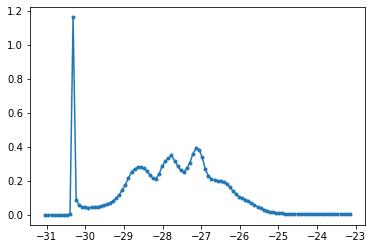

In [3]:
Nbins=100
denHist_N,denHist_bins = np.histogram(np.log10(dens.value),bins=Nbins,density=True)
bin_centers=(denHist_bins[1:]+denHist_bins[:-1])/2
plt.plot(bin_centers,denHist_N,marker='.');

In [4]:
tf.funcs[3].y.shape

(256,)

### Attempt 1: convolve within the bounds of the transfer function  

**[meh, not great, go to attempt 2](#attempt-2:-KDE-sampling)**

Ignore this method -- was a first attempt, choices are somewhat random. Attempt 2 is much better and more closely tied to how volume rendering actually works..... 

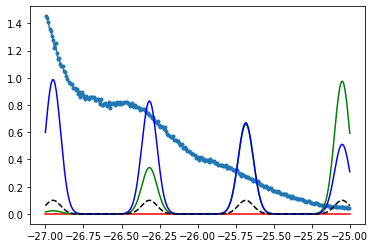

In [5]:
# get hist using bins of tranfser func to get data only in this range at same length 
x = tf.funcs[3].x
Nbins=x.shape[0]+1
xbins=np.linspace(x.min(),x.max(),Nbins)
denHist_N,denHist_bins = np.histogram(np.log10(dens.value),bins=xbins,density=True)
bin_centers=(denHist_bins[1:]+denHist_bins[:-1])/2
plt.plot(bin_centers,denHist_N,marker='.');
plt.plot(x,tf.funcs[0].y,'r')
plt.plot(x,tf.funcs[1].y,color=[0,0.5,0])
plt.plot(x,tf.funcs[2].y,'b')
plt.plot(x,tf.funcs[3].y,'--k')

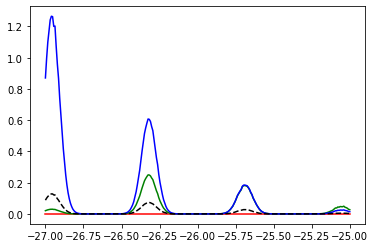

In [6]:
plt.plot(x,denHist_N*tf.funcs[0].y,'r')
plt.plot(x,denHist_N*tf.funcs[1].y,color=[0,0.5,0])
plt.plot(x,denHist_N*tf.funcs[2].y,'b')
plt.plot(x,denHist_N*tf.funcs[3].y,'--k')

In [7]:
RGBa=[]
for channel in tf.funcs:
    RGBa.append(np.trapz(denHist_N*channel.y,x=x))
    
RGBa    

[0.0, 0.06194566607578045, 0.22862729081536845, 0.025960012385254076]

So that's a representative pixel value if all the data were traversed by a ray? Does that make sense? 

Let's try a volume rendering? 

yt : [INFO     ] 2020-07-15 11:51:47,384 Rendering scene (Can take a while).
yt : [INFO     ] 2020-07-15 11:51:47,387 Creating volume


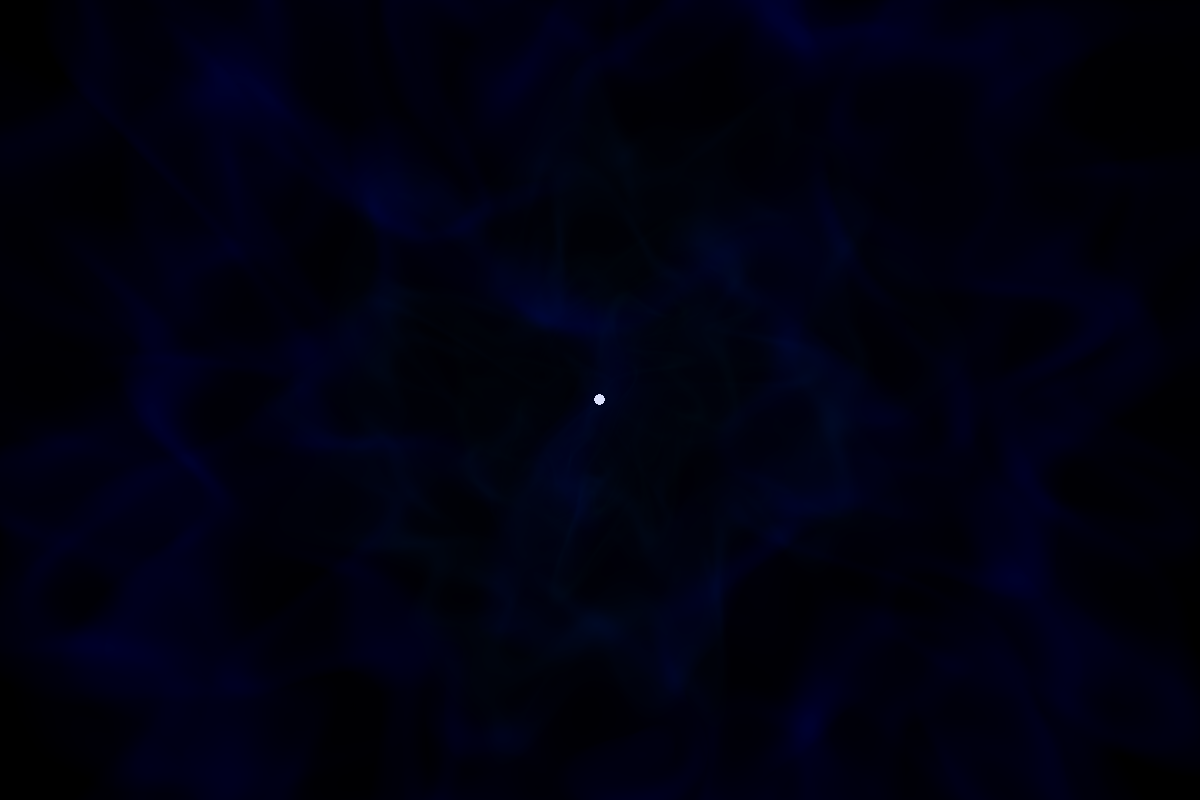

In [8]:
sc = Scene()
vol = VolumeSource(ds, field=field)
vol.use_ghost_zones = True
vol.set_transfer_function(tf)
sc.add_source(vol)

# setup the camera

cam = sc.add_camera(ds, lens_type="perspective")
cam.resolution = (1200, 800)
cam.zoom(20.0)


# add a point source
pt = 1.1*ds.domain_center

vertices = np.zeros((1, 3))
colors = np.zeros((1, 4))
colors[0, :] = (0.2, 0.2, 0.2, RGBa[-1])

radii = np.zeros((1), dtype=np.int64)

radii[0] = 5

vertices[0,:] = pt

points = PointSource(vertices, radii=radii, colors=colors)
sc.add_source(points)

The point is too bright still! The background volume is visible, so that's an improvement. But the faded volume is likely because the convolution ignores any spatial clustering of the data, so it is actually less likely for a ray to intersect a data value than what the convolution assumed. 

We can arbitrarily decrease the $\alpha$ value of the point by a factor: 

yt : [INFO     ] 2020-07-15 11:52:43,263 Rendering scene (Can take a while).
yt : [INFO     ] 2020-07-15 11:52:43,266 Creating volume


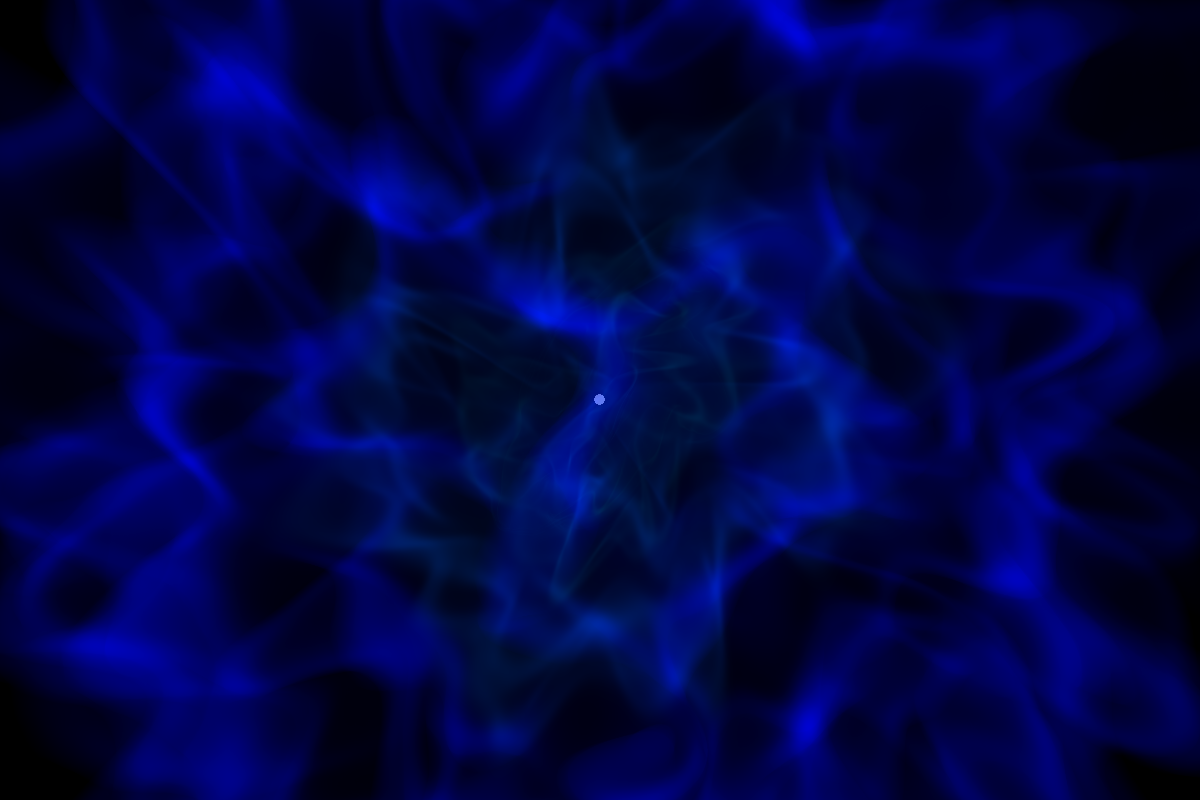

In [9]:
alpha_factor=0.1

sc = Scene()
vol = VolumeSource(ds, field=field)
vol.use_ghost_zones = True
vol.set_transfer_function(tf)
sc.add_source(vol)

# setup the camera

cam = sc.add_camera(ds, lens_type="perspective")
cam.resolution = (1200, 800)
cam.zoom(20.0)


# add a point source
pt = 1.1*ds.domain_center

vertices = np.zeros((1, 3))
colors = np.zeros((1, 4))
colors[0, :] = (0.2, 0.2, 0.2, RGBa[-1]*alpha_factor)

radii = np.zeros((1), dtype=np.int64)

radii[0] = 5

vertices[0,:] = pt

points = PointSource(vertices, radii=radii, colors=colors)
sc.add_source(points)

And we get a much more even contrast between the volume and the point. But is there a way to adjust the convolution to account for some spatial spread? Or a better approach? Hard to say if an arbitrary offset would work....


### attempt 2: KDE sampling 

In this approach, we:  

1. construct the gaussian kernal density estimate to estimate the PDE of the data 
2. randomly sample the PDE to get field data values 
3. evalulate field data values with transfer function 
4. calculate a psuedo-pixel rgb value by integrating those samples similar to the way the volume renderer does 
5. set the $\alpha$ of the point based on luminance of the pseudo-pixel 

We're still ignoring spatial distributions, but it actually doesn't do so bad on the test case.

In [10]:
from scipy import stats as scstats
logDen=np.log10(dens)
KDE=scstats.gaussian_kde(logDen)

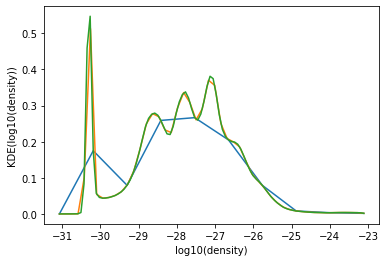

In [11]:
for Neval in [10,50,100]:
    eval_points=np.linspace(logDen.min(),logDen.max(),Neval)
    plt.plot(eval_points,KDE(eval_points))
plt.xlabel("log10(density)");
plt.ylabel("KDE(log10(density))");

In [12]:
# randomly sample the KDE: 
KDE.resample(size=10)

array([[-30.37513446, -27.11416549, -28.88639135, -28.61148898,
        -27.40989742, -26.40318809, -27.56996284, -28.46449426,
        -26.79861586, -27.70803421]])

In [13]:
# pull larger sample
SampSize=500
Samples=KDE.resample(size=SampSize)

In [14]:
# set a TF 
tf =  yt.ColorTransferFunction([-27, -25])
tf.clear()
# tf.add_layers(w=4, 0.001, alpha=np.logspace(-3, -1, 4), colormap="GnBu_r")
tf.add_layers(4, w=0.005, alpha=[.1,.1,.1,.1], colormap="winter")


# evaulate Samples with transfer function 
# uses linear interpolation of TF channels... not great, but good for this test
def evalTF(xSamples):            
    RGBa=[]
    for ichan in range(0,4):        
        TFvals=tf.funcs[ichan].y 
        xvals=tf.funcs[ichan].x       
        RGBa.append(np.interp(xSamples,xvals,TFvals,left=0.,right=0.)[0])
    return RGBa    
    
    
RGBa = evalTF(Samples)    
    
    
    
# tf.funcs[0].y # R
# tf.funcs[1].y # G 
# tf.funcs[2].y,# B
# tf.funcs[3].y # alpha

In [15]:
emiss=RGBa[0]
emiss.shape


(500,)

In [16]:
# a (too simplified?) estimate of what the volume renderer will do 

ds = 1./ len(Samples[0]) # assume our samples are spaced evenly, total distance is 1 
                         # (i.e., equal weighting)
print(ds)
psuedo_pixel=[]
# sum each channel -- probably a more clever way with cumsum? just double loop for now...
for ichan in range(0,3):
    emiss=RGBa[ichan]
    absorp=RGBa[3]
        
    chanVal=0
    for iSamp in range(0,len(Samples[0])):
        chanVal=emiss[iSamp]*ds + (1. - absorp[iSamp]*ds)*chanVal
   
    psuedo_pixel.append(chanVal)        

psuedo_pixel

0.002


[0.0, 0.009132270453852486, 0.04072166784050128]

In [17]:
# calculate luminance of the RGB of the pseudo pixel 
# see https://en.wikipedia.org/wiki/Relative_luminance
luminance = 0.2126*psuedo_pixel[0] + 0.7152*psuedo_pixel[1] + 0.0722*psuedo_pixel[2]
luminance 

0.00947150424667949

yt : [INFO     ] 2020-07-15 11:53:48,692 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-07-15 11:53:48,693 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-07-15 11:53:48,693 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-07-15 11:53:48,693 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-07-15 11:53:48,694 Parameters: cosmological_simulation   = 0.0
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 19570.48it/s]
yt : [INFO     ] 2020-07-15 11:53:48,709 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2020-07-15 11:53:49,858 Rendering scene (Can take a while).
yt : [INFO     ] 2020-07-15 11:53:49,861 Creating volume


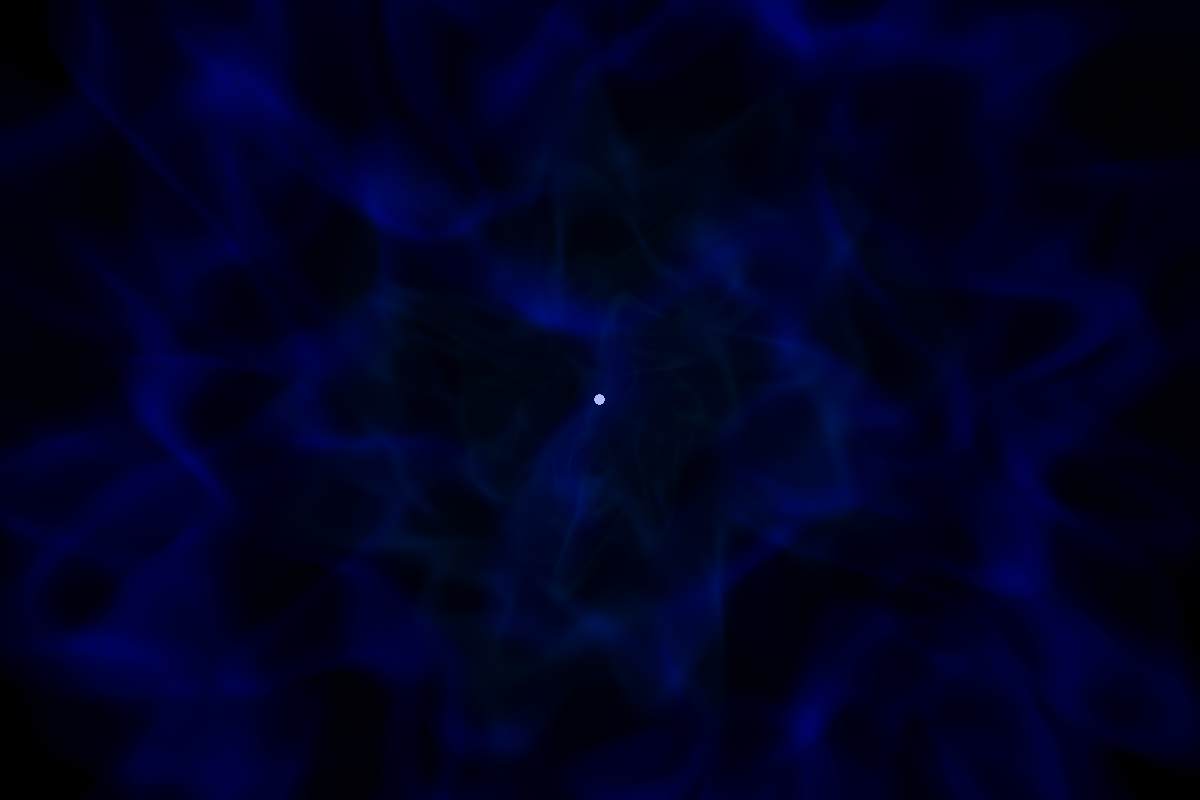

In [18]:
ds = yt.load("/home/chavlin/hdd/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030")

# create a scene and add volume sources to it

# Add density volume source 
field = "density"
ds._get_field_info(field).take_log = True

sc = Scene()
vol = VolumeSource(ds, field=field)
vol.use_ghost_zones = True
vol.set_transfer_function(tf)
sc.add_source(vol)

# setup the camera

cam = sc.add_camera(ds, lens_type="perspective")
cam.resolution = (1200, 800)
cam.zoom(20.0)


# add a point source
pt = 1.1*ds.domain_center

vertices = np.zeros((1, 3))
colors = np.zeros((1, 4))
colors[0, :] = (0.2, 0.2, 0.2, luminance)

radii = np.zeros((1), dtype=np.int64)

radii[0] = 5

vertices[0,:] = pt

points = PointSource(vertices, radii=radii, colors=colors)
sc.add_source(points)

yt : [INFO     ] 2020-07-15 12:35:36,437 Rendering scene (Can take a while).
yt : [INFO     ] 2020-07-15 12:35:36,440 Creating volume


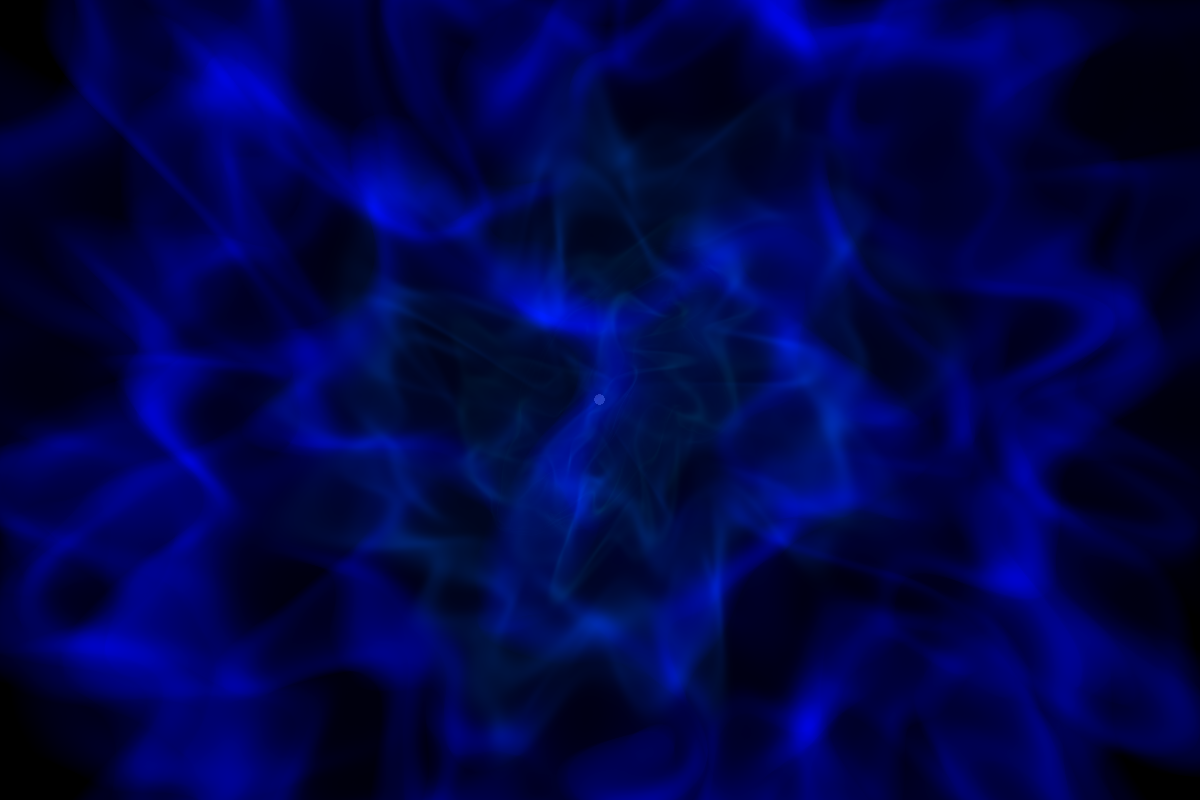

In [105]:
# too bright --- but a luminance factor makes some sense? i.e., we want the points to be 
# some factor less bright than the pseudo-pixel. Makes more sense than the arbitrary 
# decrease in the convolution method... 

lum_factor = 1./10 
sc = Scene()
vol = VolumeSource(ds, field=field)
vol.use_ghost_zones = True
vol.set_transfer_function(tf)
sc.add_source(vol)

# setup the camera

cam = sc.add_camera(ds, lens_type="perspective")
cam.resolution = (1200, 800)
cam.zoom(20.0)


# add a point source
pt = 1.1*ds.domain_center

vertices = np.zeros((1, 3))
colors = np.zeros((1, 4))
colors[0, :] = (0.2, 0.2, 0.2, luminance*lum_factor)

radii = np.zeros((1), dtype=np.int64)

radii[0] = 5

vertices[0,:] = pt

points = PointSource(vertices, radii=radii, colors=colors)
sc.add_source(points)

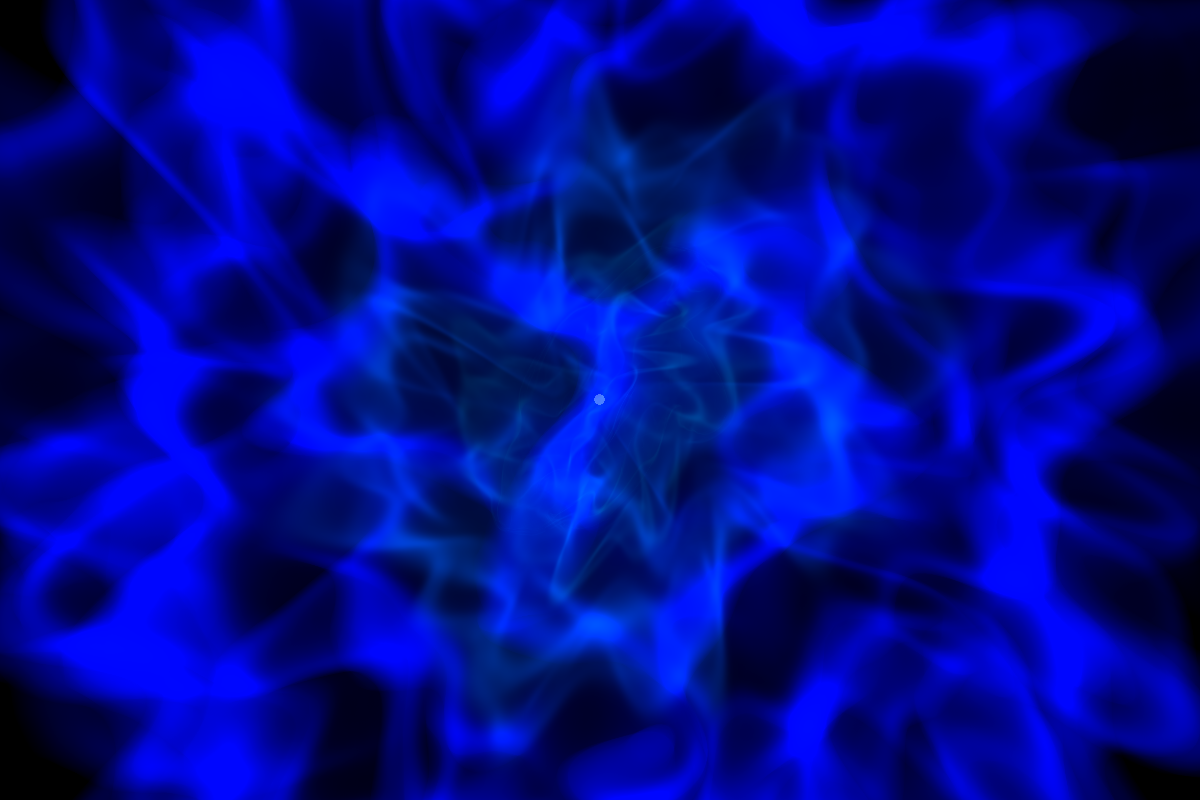

In [20]:
# gets it close enough that using sigma clipping works well? 
sc.show(sigma_clip=2)

Need to try a bunch more test cases with different datasets....... 

## post-processing methods

The `sigma_clip` adjustment is a post-processing method: it takes the final image array and clips values based on standard deviations of the pixel values. It would be possible to pass and apply any contrast adjustment function to the image writer... e.g., https://scikit-image.org/docs/stable/api/skimage.exposure.html 


In the following examples, we take the output image array from a rendering and apply adjustments directly to the array.

yt : [INFO     ] 2020-07-15 12:40:37,177 Rendering scene (Can take a while).
yt : [INFO     ] 2020-07-15 12:40:37,180 Creating volume


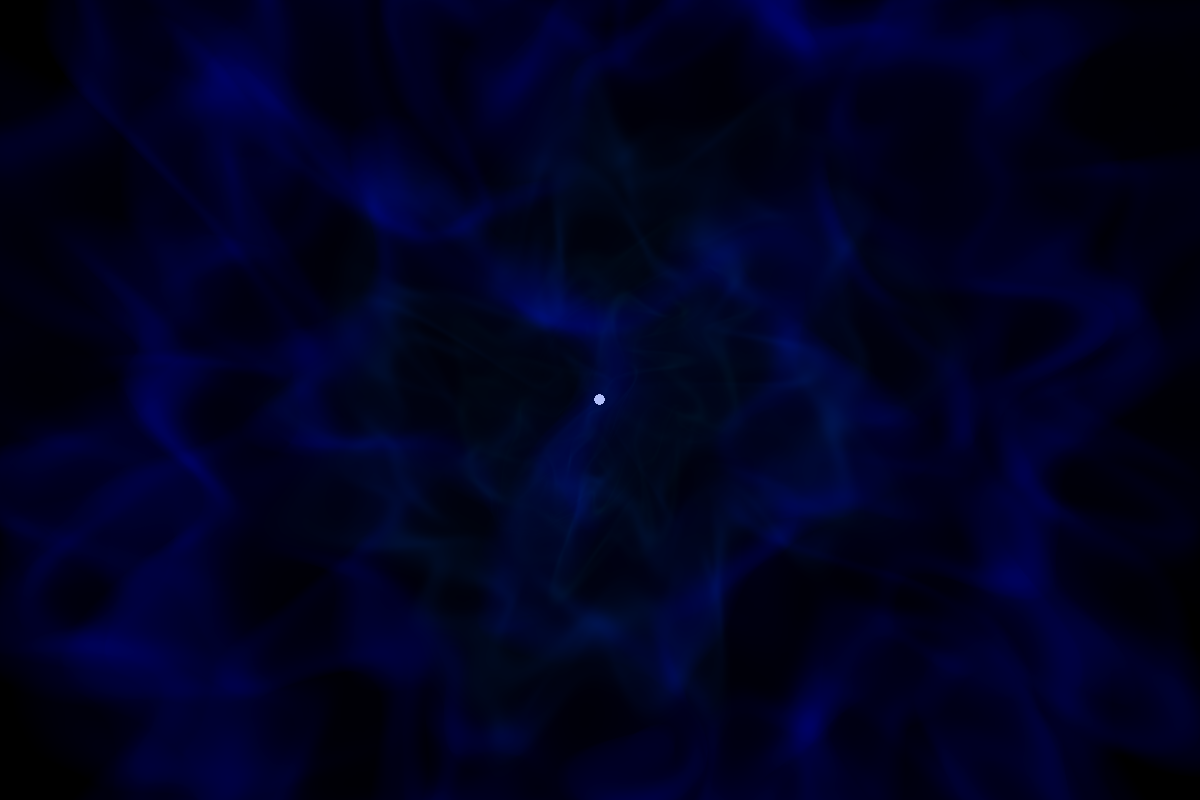

In [122]:
# first, let's reset everything and render 
sc = Scene()
vol = VolumeSource(ds, field=field)
vol.use_ghost_zones = True
vol.set_transfer_function(tf)
sc.add_source(vol)

# setup the camera

cam = sc.add_camera(ds, lens_type="perspective")
cam.resolution = (1200, 800)
cam.zoom(20.0)


# add a point source
pt = 1.1*ds.domain_center

vertices = np.zeros((1, 3))
colors = np.zeros((1, 4))
colors[0, :] = (0.2, 0.2, 0.2, .01)

radii = np.zeros((1), dtype=np.int64)

radii[0] = 5

vertices[0,:] = pt

points = PointSource(vertices, radii=radii, colors=colors)
sc.add_source(points)
sc.render()
sc.show()

In [140]:
# now, let's get the image array 
im=sc._last_render

In [124]:
type(im)

yt.data_objects.image_array.ImageArray

In [125]:
type(im.value)

numpy.ndarray

In [126]:
im.shape

(1200, 800, 4)

In [127]:
# and import the exposure module and yt ImageArray class
from skimage import exposure 
from yt.data_objects.image_array import ImageArray

In [128]:
# check constrat of the image array 
exposure.is_low_contrast(im)

True

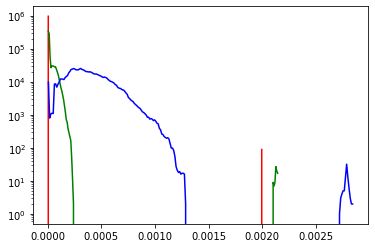

In [129]:
# histograms of the RGB channels
clrdict={0:'r',1:'g',2:'b',3:'k'}
for ichan in range(0,3):
    histarray, bincenters=exposure.histogram(im[:,:,ichan])
    plt.semilogy(bincenters,histarray,color=clrdict[ichan])

plt.show()

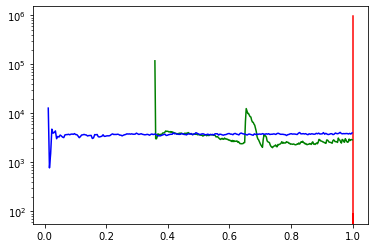

In [130]:
# let's equalize each channel? things might get crazy!
for ichan in range(0,3):
    histarray, bincenters=exposure.histogram(exposure.equalize_hist(im[:,:,ichan]))
    plt.semilogy(bincenters,histarray,color=clrdict[ichan])
plt.show()


In [131]:
# modify the image array
type(exposure.rescale_intensity(im.value))

numpy.ndarray

In [132]:
im_init=ImageArray(np.copy(sc._last_render.value)) # save the initial first

In [133]:
# equalize each channel!
for ichan in range(0,3):
    im[:,:,ichan]=exposure.equalize_hist(im[:,:,ichan])
type(im)

yt.data_objects.image_array.ImageArray

In [134]:
# overwrite the _last_render with our modified ImageArray
sc._last_render=im

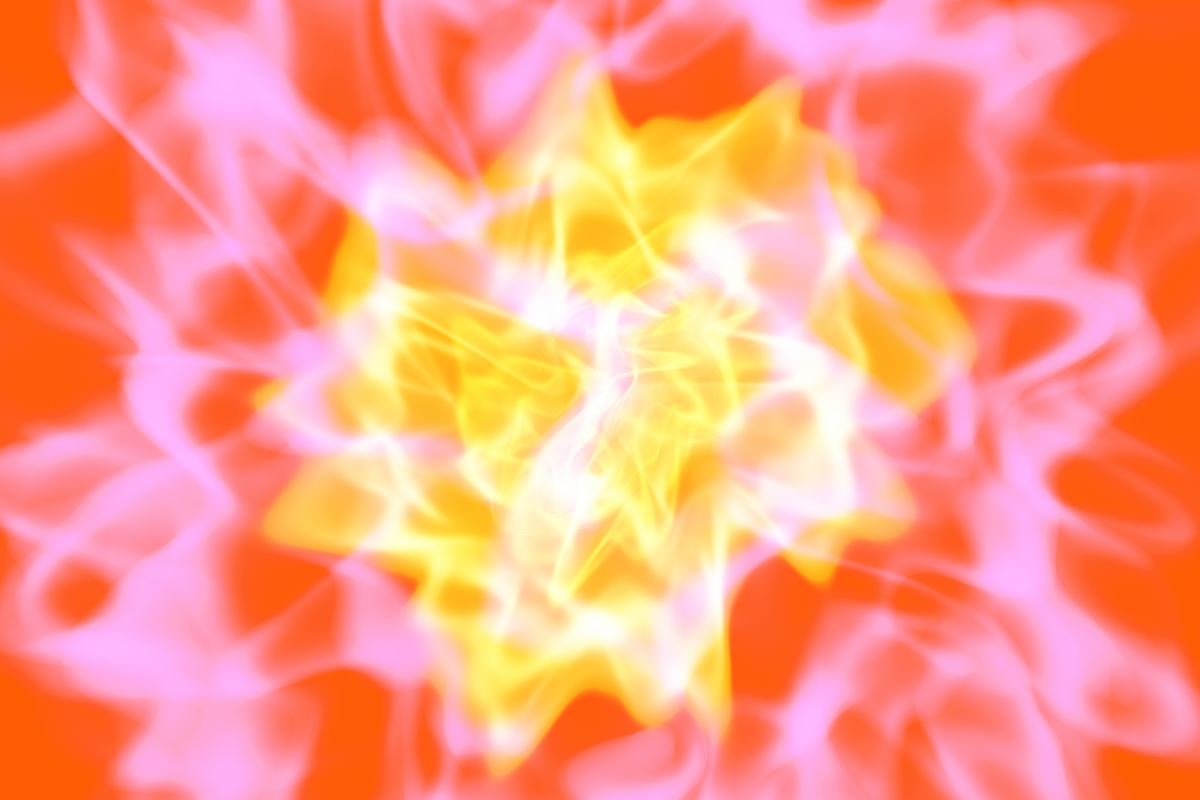

In [135]:
sc.show()

hahahahaha. well it's not low contrast anymore: 

In [136]:
exposure.is_low_contrast(im)

False

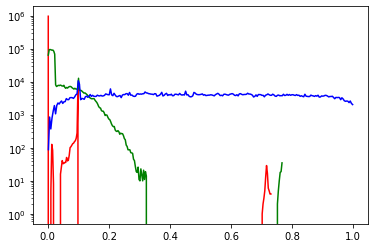

In [139]:
# equalize_adapthist works with color images. From the docs: 
# For color images, the following steps are performed:
#         The image is converted to HSV color space
#         The CLAHE algorithm is run on the V (Value) channel
#         The image is converted back to RGB space and returned


im = ImageArray(np.copy(im_init.value))
im[:,:,0:3] = exposure.equalize_adapthist(im[:,:,0:3],clip_limit=.1) # don't include alpha
for ichan in range(0,3):
    histarray, bincenters=exposure.histogram(im[:,:,ichan])
    plt.semilogy(bincenters,histarray,color=clrdict[ichan])
plt.show()

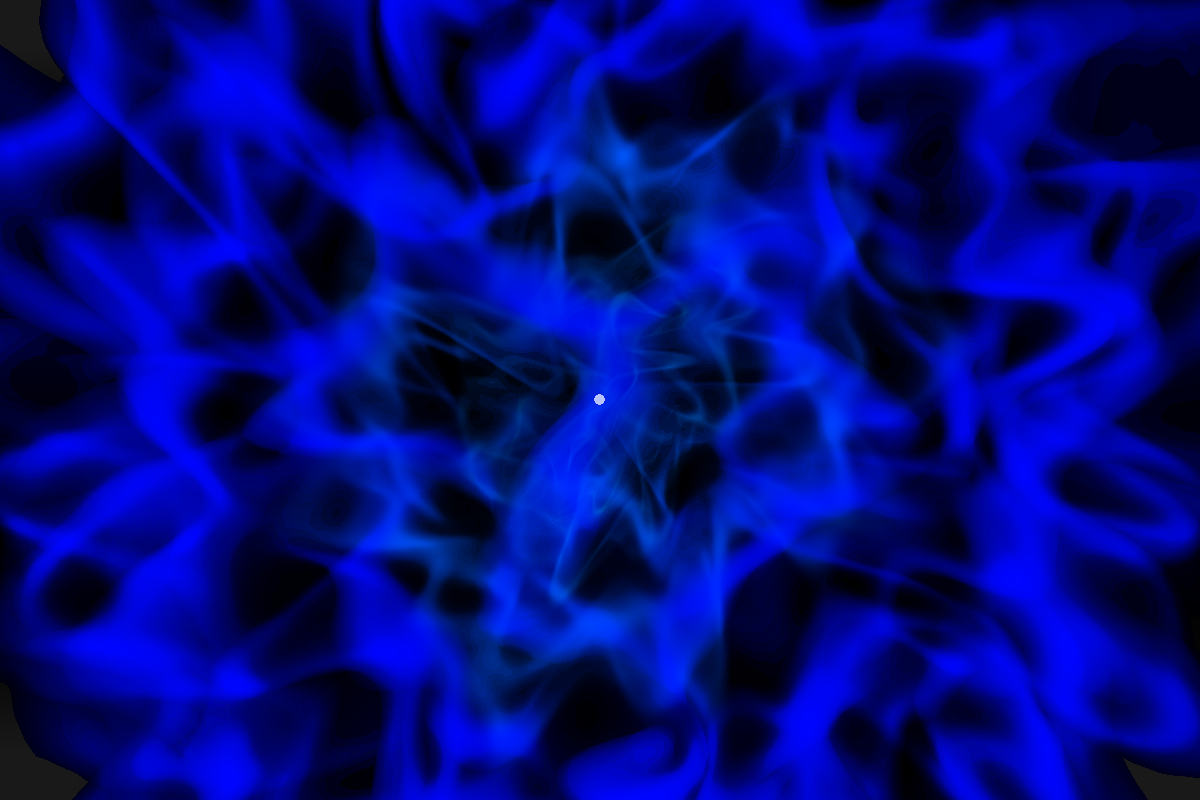

In [138]:
sc._last_render=im
sc.show()

In [120]:
exposure.is_low_contrast(im)

False

oh wow, that's pretty good! 